In [1]:
import pandas as pd
import numpy as np
from decimal import Decimal
from collections import namedtuple
import matplotlib.pyplot as plt

In [2]:
Kouhou2 = namedtuple( 'kouhou2', ( 'NM', 'HB', 'src' ) )
Kouhou4 = namedtuple( 'kouhou4', ( 'NM_NM', 'HB_NM', 'NM_HB', 'HB_HB', 'src' ) )

# U値を計算する方法

断熱材のR値や厚さ、構法／工法、付加断熱の有無と付加断熱をした場合のR値等から、簡易的にU値を計算する方法を示す。

## 基本構成

壁・屋根／天井・床・ドア・窓の、1つ1つを部位という。  
1つの部位は、複数の部分を持ち、熱は並列的に複数の部分を通過する。  
壁・屋根／天井は、断熱材の充填が可能な一般部と、構造用の柱・梁など断熱材が充填できない熱橋部の2つの部分を持つ。  
床も、一般部と熱橋部の2つに分かれるが、根太レベルと大引きレベルの両方に断熱材を施工する場合は、構造的に根太と大引きが直角方向に配置されるため、床上側から床下側を見ると、  
・根太レベルが一般部で、大引きレベルも一般部、  
・根太レベルが熱橋部で、大引きレベルは一般部、  
・根太レベルが一般部で、大引きレベルも熱橋部、  
・根太レベルが熱橋部で、大引きレベルは熱橋部、  
の4つの部分を持つことがある。  
各部分は、複数の層を持ち、熱は直列的に複数の層を通過する。層として例えば、石膏ボード、合板、断熱材などが挙げられる。  
窓は、枠と可動部に分かれる。可動部はサッシとグレージングに分かれる。グレージングは透明であり、枠とサッシは不透明である。透明か不透明かで計算方法が異なるため、計算方法としては、枠とサッシの計算とグレージングの計算に分かれる。枠とサッシを合わせて建具と呼ぶ。  
ドアは、性格にはドアセットと言い、可動部分のみをドアと言う。ドアセットは枠とドアからなる。ドアは不透明なパネルのみで構成される場合と、グレージングがはめこまれる場合がある。  
計算方法は窓とドアで大きく異なるが、本来であれば大部分が透明な部分で構成されているか、大部分が不透明な部分で構成されているかで分類すべきである。従って、全面ガラスがはめこまれた框ドアは窓の計算方法が適用される。一方で、板戸などの不透明な窓はドアの計算方法が適用される。

## 1) 外壁(簡略法)

木造における外壁の面積比率を示す。

|                                                    | $a_{wall,NM}$ | $a_{wall,HB}$ | 層構造   |
|:--------------------------------------------------:|:-------------:|:-------------:|:--------:|
| 軸組構法で柱・間柱間に断熱する場合                 | 0.83          | 0.17          | 充填     |
| 軸組構法で柱・間柱間に断熱し付加断熱する場合       | 0.83          | 0.17          | 外張充填 |
| 枠組壁工法でたて枠間に断熱する場合                 | 0.77          | 0.23          | 充填     |
| 枠組壁工法でたて枠間に断熱し付加断熱する場合       | 0.77          | 0.23          | 外張充填 |
| 軸組み構法および枠組壁工法において外張断熱する場合 | 1.0           | 0.0           | 外張     |

In [3]:
def WallPart( kouhou ):
    # kouhou: 構法・工法
    #   'Jik'       : 軸組構法で柱・間柱間に断熱する場合
    #   'Jik_huka'  : 軸組構法で柱・間柱間に断熱し付加断熱する場合
    #   'Waku'      : 枠組壁工法でたて枠間に断熱する場合
    #   'Waku_huka' : 枠組壁工法でたて枠間に断熱し付加断熱する場合
    #   'Sotobari'  : 軸組み構法および枠組壁工法において外張断熱する場合
    
    if   ( kouhou == 'Jik' ):       return Kouhou2( 0.83, 0.17, 'J' )
    elif ( kouhou == 'Jik_huka' ):  return Kouhou2( 0.83, 0.17, 'D' )
    elif ( kouhou == 'Waku' ):      return Kouhou2( 0.77, 0.23, 'J' )
    elif ( kouhou == 'Waku_huka' ): return Kouhou2( 0.77, 0.23, 'D'  )
    elif ( kouhou == 'Sotobari' ):  return Kouhou2( 1.0,  0.0,  'S' )
    else: raise ( 'value error of kouhou in U_wall_simple' )

In [4]:
WallPart('Jik')

kouhou2(NM=0.83, HB=0.17, src='J')

### 部位のU値の算出式

$ \begin{align} U_{wall} = a_{wall,NM} \times U_{wall,NM} + a_{wall,HB} \times U_{wall,HB} \end{align} $  

$ U_{wall} $: 壁のU値(W/m<sup>2</sup>K)  
$ a_{wall,NM} $: 壁の一般部の面積割合  
$ a_{wall,HB} $: 壁の熱橋部の面積割合  
$ U_{wall,NM} $: 壁の一般部のU値(W/m<sup>2</sup>K)  
$ U_{wall,HB} $: 壁の熱橋部のU値(W/m<sup>2</sup>K)  

In [5]:
def U_wall_simple( gaiki, kouhou, lambda_ins, thick_ins, lambda_ins2, thick_ins2  ):
    # gaiki: 外気の種類　直接面している場合は True それ以外（通気層など）はFalse
    # kouhou: 構法・工法
    #   'Jik'       : 軸組構法で柱・間柱間に断熱する場合
    #   'Jik_huka'  : 軸組構法で柱・間柱間に断熱し付加断熱する場合
    #   'Waku'      : 枠組壁工法でたて枠間に断熱する場合
    #   'Waku_huka' : 枠組壁工法でたて枠間に断熱し付加断熱する場合
    #   'Sotobari'  : 軸組み構法および枠組壁工法において外張断熱する場合
    # lambda_ins: 断熱材の熱伝導率(W/mK)
    # thick_ins: 断熱材の厚さ(m)
    # lambda_ins2: 2層目の断熱材の熱伝導率(W/mK) wp.src = 'J'&'S' の場合はこの値は無視される
    # thick_ins2: 2層目の断熱材の厚さ(m) wp.src = 'J'&'S' の場合はこの値は無視される
    
    wp = WallPart(kouhou)
    
    # U_NM: 壁の一般部のU値(W/m2K)
    # U_HB: 壁の熱橋部のU値(W/m2K)
    U_NM, U_HB = U_wall_simple_part( gaiki, wp.src, lambda_ins, thick_ins, lambda_ins2, thick_ins2 )
    
    return wp.NM * U_NM + wp.HB * U_HB

### 部分のU値の算出式

部位のU値

一般部  
$ \begin{align} U_{wall,NM} = \frac {1}{ R_{wall,se} + R_{wall,si} + R_{wall,NM} } \end{align} $  

熱橋部  
$ \begin{align} U_{wall,HB} = \frac {1}{ R_{wall,se} + R_{wall,si} + R_{wall,HB} } \end{align} $  

表面熱伝達抵抗(m<sup>2</sup>K/W)  
室内側($R_{wall,si}$): 0.11  
室外側($R_{wall,se}$): 0.04(通気層等なし), 0.11(通気層等あり)

充填断熱の場合  
一般部のR値  
$ \begin{align} R_{wall,NM} = \frac{ \lambda_{wall,Ins} }{ l_{wall,Ins} } \end{align} $  
熱橋部のR値  
$ \begin{align} R_{wall,HB} = \frac{ \lambda_{wood} }{ l_{wall,Ins} } \end{align} $  

外張断熱の場合  
一般部のR値  
$ \begin{align} R_{wall,NM} = \frac{ \lambda_{wall,Ins} }{ l_{wall,Ins} } \times 0.9 \end{align} $  
熱橋部のR値  
外張断熱の場合、胴縁はR値に低減係数0.9を乗じることで考慮しているため、計算上熱橋部はなしとして扱う。 

充填断熱＋外張断熱の場合  
一般部のR値  
$ \begin{align} R_{wall,NM} = \frac{ \lambda_{wall,Ins} }{ l_{wall,Ins} } + \frac{ \lambda_{wall,Ins2} }{ l_{wall,Ins2} } \times 0.9 \end{align} $  
熱橋部のR値  
$ \begin{align} R_{wall,HB} = \frac{ \lambda_{wood} }{ l_{wall,Ins} } + \frac{ \lambda_{wall,Ins2} }{ l_{wall,Ins2} } \times 0.9 \end{align} $  

$\lambda$: 熱伝導率(W/mK)  
$l$: 断熱材の厚さ(m)  
Ins: 断熱材  
Ins2: 2層目の断熱材(充填断熱時の外張断熱)  
wood: 天然木材  

天然木材の熱伝導率は0.12  
係数0.9は、外張工法の胴縁等による熱抵抗の減少を表す係数

In [6]:
def U_wall_simple_part( gaiki, src, lambda_ins, thick_ins, lambda_ins2, thick_ins2 ):
    # gaiki: 外気の種類　直接面している場合は True それ以外（通気層など）はFalse
    # src: 構造 'J'=充填断熱, 'S'=外張断熱 'D':充填かつ外張断熱
    # lambda_ins: 断熱材の熱伝導率(W/mK)
    # thick_ins: 断熱材の厚さ(m)
    # lambda_ins2: 2層目の断熱材の熱伝導率(W/mK) src = 'J'&'S' の場合はこの値は無視される
    # thick_ins2: 2層目の断熱材の厚さ(m) src = 'J'&'S' の場合はこの値は無視される
    
    lambda_wood = 0.12

    if( src == 'J' ):
        R_NM = thick_ins / lambda_ins
        R_HB = thick_ins / lambda_wood
    elif( src == 'S' ):
        R_NM = thick_ins / lambda_ins * 0.9
        R_HB = 0.0
    elif( src == 'D' ):
        R_NM = thick_ins / lambda_ins  + thick_ins2 / lambda_ins2 * 0.9
        R_HB = thick_ins / lambda_wood + thick_ins2 / lambda_ins2 * 0.9
    else:
        raise( 'wrong src value in U_wall_simple_part' )

    # 室内側熱伝達抵抗(m2K/W)
    R_si = 0.11
    
    # 室外側熱伝達抵抗(m2K/W)
    R_se = 0.04 if gaiki else 0.11
    
    # U_NM: 壁の一般部のU値(W/m2K)
    U_NM = 1 / ( R_si + R_se + R_NM )

    # U_HB: 壁の熱橋部のU値(W/m2K)
    U_HB = 1 / ( R_si + R_se + R_HB )
    
    return ( U_NM, U_HB )

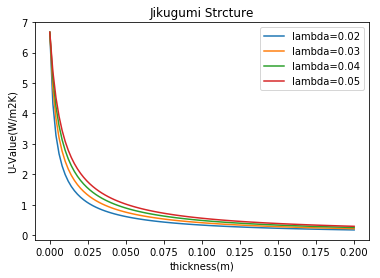

In [7]:
t = np.linspace(0,0.2,100)

plt.xlabel('thickness(m)')
plt.ylabel('U-Value(W/m2K)')
plt.title('Jikugumi Strcture')
for l in [0.02,0.03,0.04,0.05]:
    plt.plot( t, U_wall_simple( True, 'Jik', l, t, 0, 0 ), label = 'lambda='+str(l) )
plt.legend()
plt.show()

### テスト

In [8]:
test_input = []

    # 第1引数 gaiki: 外気の種類　直接面している場合は True それ以外（通気層など）はFalse
    # 第2引数 kouhou: 構法・工法
    #   'Jik'       : 軸組構法で柱・間柱間に断熱する場合
    #   'Jik_huka'  : 軸組構法で柱・間柱間に断熱し付加断熱する場合
    #   'Waku'      : 枠組壁工法でたて枠間に断熱する場合
    #   'Waku_huka' : 枠組壁工法でたて枠間に断熱し付加断熱する場合
    #   'Sotobari'  : 軸組み構法および枠組壁工法において外張断熱する場合
    # 第3引数 lambda_ins: 断熱材の熱伝導率(W/mK)
    # 第4引数 thick_ins: 断熱材の厚さ(m)
    # 第5引数 lambda_ins2: 2層目の断熱材の熱伝導率(W/mK) wp.src = 'J'&'S' の場合はこの値は無視される
    # 第6引数 thick_ins2: 2層目の断熱材の厚さ(m) wp.src = 'J'&'S' の場合はこの値は無視される

test_input.append( [ True,  'Jik'       , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ True,  'Jik_huka'  , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ True,  'Waku'      , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ True,  'Waku_huka' , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ True,  'Sotobari'  , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ False, 'Jik'       , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ False, 'Jik_huka'  , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ False, 'Waku'      , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ False, 'Waku_huka' , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ False, 'Sotobari'  , 0.042, 0.05, 0.042, 0.05] )

In [9]:
test_output = []
for t in test_input:
    test_output.append( U_wall_simple( t[0], t[1], t[2], t[3], t[4], t[5] ) )
test_output

[0.919182948490231,
 0.4479054271218348,
 0.9803050882875354,
 0.4596567299524783,
 0.8187134502923977,
 0.8554694542742098,
 0.4339466342708951,
 0.9071714668523815,
 0.4448985004046975,
 0.7743362831858407]

### 簡易法2との比較

今回示す方法とは全く別に、「簡易法2」が存在し、U値は以下の式で表される。  
$ \begin{align} U = \frac{1}{R_{ins}} + U_r \end{align} $

$R_{ins}$: 断熱材のR値(m<sup>2</sup>K/W)  
$U_r$: 補正貫流率(W/m<sup>2</sup>K)

補正貫流率は断熱工法等に応じて以下の値をとる。

| 断熱工法等                                     | 軸組構法 | 枠組壁工法 |
|:----------------------------------------------:|:--------:|:----------:|
| 充填断熱（柱・間柱間に断熱）する場合           | 0.09     | 0.13       |
| 充填断熱（柱・間柱間に断熱）し付加断熱する場合 | 0.09     | 0.13       |
| 土壁で外張断熱する場合                         | 0.04     | 0.04       |
| 土壁以外で外張断熱する場合                     | 0.02     | 0.02       |

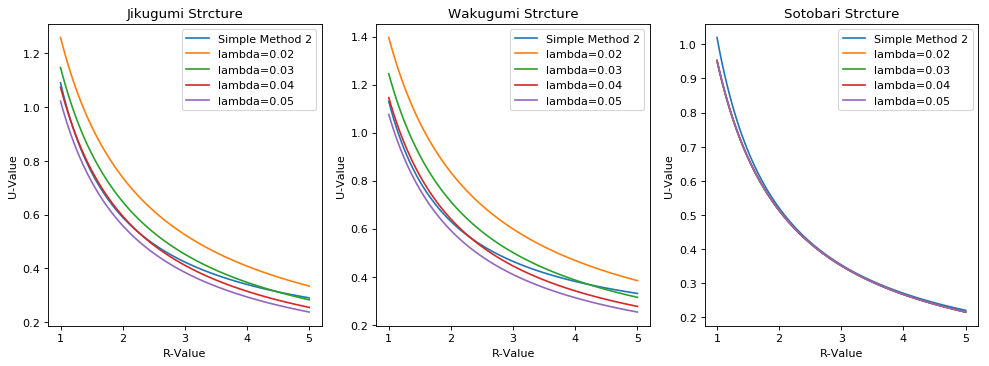

In [10]:
plt.figure(figsize=(15,5),dpi=80)

R = np.linspace(1,5,100)

plt.subplot(131)
plt.xlabel('R-Value')
plt.ylabel('U-Value')
plt.title('Jikugumi Strcture')
plt.plot( R, 1/R+0.09, label = 'Simple Method 2')
for l in [ 0.02, 0.03, 0.04, 0.05 ]:
    plt.plot( R, U_wall_simple( True, 'Jik', l, l*R, 0, 0 ), label = 'lambda='+str(l) )
plt.legend()

plt.subplot(132)
plt.title('Wakugumi Strcture')
plt.xlabel('R-Value')
plt.ylabel('U-Value')
plt.plot( R, 1/R+0.13, label = 'Simple Method 2')
for l in [ 0.02, 0.03, 0.04, 0.05 ]:
    plt.plot( R, U_wall_simple( True, 'Waku', l, l*R, 0, 0 ), label = 'lambda='+str(l) )
plt.legend()

plt.subplot(133)
plt.title('Sotobari Strcture')
plt.xlabel('R-Value')
plt.ylabel('U-Value')
plt.plot( R, 1/R+0.02, label = 'Simple Method 2')
for l in [ 0.02, 0.03, 0.04, 0.05 ]:
    plt.plot( R, U_wall_simple( True, 'Sotobari', l, l*R, 0, 0 ), label = 'lambda='+str(l) )
plt.legend()

plt.show()

## 2) 屋根または天井(簡略法)

木造における屋根または天井の面積比率を示す。

|                                                      | $a_{roof,NM}$ | $a_{roof,HB}$ | 層構造   |
|:----------------------------------------------------:|:-------------:|:-------------:|:--------:|
| 天井断熱工法において梁や桁間に断熱する場合           | 0.87          | 0.13          | 充填     |
| 天井断熱工法において天井一面に断熱する場合           | 1.0           | 0.0           | 充填     |
| 屋根断熱工法においてたるき間に断熱する場合           | 0.86          | 0.14          | 充填     |
| 屋根断熱工法において外張断熱する場合                 | 1.0           | 0.0           | 外張     |
| 屋根断熱工法においてたるき間に断熱し付加断熱する場合 | 0.86          | 0.14           | 外張充填 |

In [11]:
def RoofPart( kouhou ):
    # kouhou: 構法・工法
    #   'Hari_Keta'   : 天井断熱工法において梁や桁間に断熱する場合
    #   'Tenjou'      : 天井断熱工法において天井一面に断熱する場合
    #   'Taruki'      : 屋根断熱工法においてたるき間に断熱する場合
    #   'Sotobari'    : 屋根断熱工法において外張断熱する場合
    #   'Taruki_huka' : 屋根断熱工法においてたるき間に断熱し付加断熱する場合
    
    if   ( kouhou == 'Hari_Keta' ):   return Kouhou2( 0.87, 0.13, 'J' )
    elif ( kouhou == 'Tenjou' ):      return Kouhou2( 1.0,  0.0,  'J' )
    elif ( kouhou == 'Taruki' ):      return Kouhou2( 0.86, 0.14, 'J' )
    elif ( kouhou == 'Sotobari' ):    return Kouhou2( 1.0,  0.0,  'S' )
    elif ( kouhou == 'Taruki_huka' ): return Kouhou2( 0.86, 0.14, 'D' )
    else: raise ( 'value error of kouhou in U_wall_simple' )

In [12]:
RoofPart('Hari_Keta')

kouhou2(NM=0.87, HB=0.13, src='J')

### 部位のU値の算出式

$ \begin{align} U_{roof} = a_{roof,NM} \times U_{roof,NM} + a_{roof,HB} \times U_{roof,HB} \end{align} $  

$ U_{roof} $: 屋根・天井のU値(W/m<sup>2</sup>K)  
$ a_{roof,NM} $: 屋根・天井の一般部の面積割合  
$ a_{roof,HB} $: 屋根・天井の熱橋部の面積割合  
$ U_{roof,NM} $: 屋根・天井の一般部のU値(W/m<sup>2</sup>K)  
$ U_{roof,HB} $: 屋根・天井の熱橋部のU値(W/m<sup>2</sup>K)  

In [13]:
def U_roof_simple( gaiki, kouhou, lambda_ins, thick_ins, lambda_ins2, thick_ins2  ):
    # gaiki: 外気の種類　直接面している場合は True それ以外（通気層など）はFalse
    # kouhou: 構法・工法
    #   'Hari_Keta'   : 天井断熱工法において梁や桁間に断熱する場合
    #   'Tenjou'      : 天井断熱工法において天井一面に断熱する場合
    #   'Taruki'      : 屋根断熱工法においてたるき間に断熱する場合
    #   'Sotobari'    : 屋根断熱工法において外張断熱する場合
    #   'Taruki_huka' : 屋根断熱工法においてたるき間に断熱し付加断熱する場合
    # lambda_ins: 断熱材の熱伝導率(W/mK)
    # thick_ins: 断熱材の厚さ(m)
    # lambda_ins2: 2層目の断熱材の熱伝導率(W/mK) wp.src = 'J'&'S' の場合はこの値は無視される
    # thick_ins2: 2層目の断熱材の厚さ(m) wp.src = 'J'&'S' の場合はこの値は無視される
    
    wp = RoofPart(kouhou)
    
    # U_NM: 壁の一般部のU値(W/m2K)
    # U_HB: 壁の熱橋部のU値(W/m2K)
    U_NM, U_HB = U_roof_simple_part( gaiki, wp.src, lambda_ins, thick_ins, lambda_ins2, thick_ins2 )
    
    return wp.NM * U_NM + wp.HB * U_HB

### 部分のU値の算出式

部位のU値

一般部  
$ \begin{align} U_{roof,NM} = \frac {1}{ R_{roof,se} + R_{roof,si} + R_{roof,NM} } \end{align} $  

熱橋部  
$ \begin{align} U_{roof,HB} = \frac {1}{ R_{roof,se} + R_{roof,si} + R_{roof,HB} } \end{align} $  

表面熱伝達抵抗(m<sup>2</sup>K/W)  
室内側($R_{wall,si}$): 0.09  
室外側($R_{wall,se}$): 0.04(通気層等なし), 0.09(通気層・小屋裏等あり)

充填断熱の場合  
一般部のR値  
$ \begin{align} R_{roof,NM} = \frac{ \lambda_{roof,Ins} }{ l_{roof,Ins} } \end{align} $  
熱橋部のR値  
$ \begin{align} R_{roof,HB} = \frac{ \lambda_{wood} }{ l_{roof,Ins} } \end{align} $  

外張断熱の場合  
一般部のR値  
$ \begin{align} R_{roof,NM} = \frac{ \lambda_{roof,Ins} }{ l_{roof,Ins} } \times 0.9 \end{align} $  
熱橋部のR値  
外張断熱の場合、胴縁はR値に低減係数0.9を乗じることで考慮しているため、計算上熱橋部はなしとして扱う。 

充填断熱＋外張断熱の場合  
一般部のR値  
$ \begin{align} R_{roof,NM} = \frac{ \lambda_{roof,Ins} }{ l_{roof,Ins} } + \frac{ \lambda_{roof,Ins2} }{ l_{roof,Ins2} } \times 0.9 \end{align} $  
熱橋部のR値  
$ \begin{align} R_{roof,HB} = \frac{ \lambda_{wood} }{ l_{roof,Ins} } + \frac{ \lambda_{roof,Ins2} }{ l_{roof,Ins2} } \times 0.9 \end{align} $  

$\lambda$: 熱伝導率(W/mK)  
$l$: 断熱材の厚さ(m)  
Ins: 断熱材  
Ins2: 2層目の断熱材(充填断熱時の外張断熱)  
wood: 天然木材  

天然木材の熱伝導率は0.12  
係数0.9は、外張工法の胴縁等による熱抵抗の減少を表す係数

In [14]:
def U_roof_simple_part( gaiki, src, lambda_ins, thick_ins, lambda_ins2, thick_ins2 ):
    # gaiki: 外気の種類　直接面している場合は True それ以外（通気層など）はFalse
    # src: 構造 'J'=充填断熱, 'S'=外張断熱 'D':充填かつ外張断熱
    # lambda_ins: 断熱材の熱伝導率(W/mK)
    # thick_ins: 断熱材の厚さ(m)
    # lambda_ins2: 2層目の断熱材の熱伝導率(W/mK) src = 'J'&'S' の場合はこの値は無視される
    # thick_ins2: 2層目の断熱材の厚さ(m) src = 'J'&'S' の場合はこの値は無視される
    
    lambda_wood = 0.12

    if( src == 'J' ):
        R_NM = thick_ins / lambda_ins
        R_HB = thick_ins / lambda_wood
    elif( src == 'S' ):
        R_NM = thick_ins / lambda_ins * 0.9
        R_HB = 0.0
    elif( src == 'D' ):
        R_NM = thick_ins / lambda_ins  + thick_ins2 / lambda_ins2 * 0.9
        R_HB = thick_ins / lambda_wood + thick_ins2 / lambda_ins2 * 0.9
    else:
        raise( 'wrong src value in U_wall_simple_part' )

    # 室内側熱伝達抵抗(m2K/W)
    R_si = 0.09
    
    # 室外側熱伝達抵抗(m2K/W)
    R_se = 0.04 if gaiki else 0.09
    
    # U_NM: 壁の一般部のU値(W/m2K)
    U_NM = 1 / ( R_si + R_se + R_NM )

    # U_HB: 壁の熱橋部のU値(W/m2K)
    U_HB = 1 / ( R_si + R_se + R_HB )
    
    return ( U_NM, U_HB )

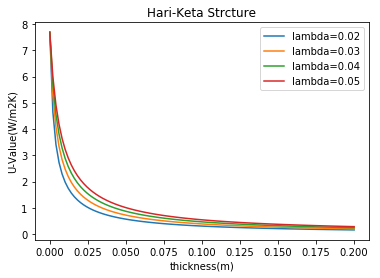

In [15]:
t = np.linspace(0,0.2,100)

plt.xlabel('thickness(m)')
plt.ylabel('U-Value(W/m2K)')
plt.title('Hari-Keta Strcture')
for l in [0.02,0.03,0.04,0.05]:
    plt.plot( t, U_roof_simple( True, 'Hari_Keta', l, t, 0, 0 ), label = 'lambda='+str(l) )
plt.legend()
plt.show()

### テスト

In [16]:
test_input = []

    # 第1引数 gaiki: 外気の種類　直接面している場合は True それ以外（通気層など）はFalse
    # 第2引数 kouhou: 構法・工法
    #   'Hari_Keta'   : 天井断熱工法において梁や桁間に断熱する場合
    #   'Tenjou'      : 天井断熱工法において天井一面に断熱する場合
    #   'Taruki'      : 屋根断熱工法においてたるき間に断熱する場合
    #   'Sotobari'    : 屋根断熱工法において外張断熱する場合
    #   'Taruki_huka' : 屋根断熱工法においてたるき間に断熱し付加断熱する場合
    # 第3引数 lambda_ins: 断熱材の熱伝導率(W/mK)
    # 第4引数 thick_ins: 断熱材の厚さ(m)
    # 第5引数 lambda_ins2: 2層目の断熱材の熱伝導率(W/mK) wp.src = 'J'&'S' の場合はこの値は無視される
    # 第6引数 thick_ins2: 2層目の断熱材の厚さ(m) wp.src = 'J'&'S' の場合はこの値は無視される

test_input.append( [ True,  'Hari_Keta'  , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ True,  'Tenjou'     , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ True,  'Taruki'     , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ True,  'Sotobari'   , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ True,  'Taruki_huka', 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ False, 'Hari_Keta'  , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ False, 'Tenjou'     , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ False, 'Taruki'     , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ False, 'Sotobari'   , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ False, 'Taruki_huka', 0.042, 0.05, 0.042, 0.05] )

In [17]:
test_output = []
for t in test_input:
    test_output.append( U_roof_simple( t[0], t[1], t[2], t[3], t[4], t[5] ) )
test_output

[0.8966581056001688,
 0.7573025604038947,
 0.9073777629229591,
 0.8323424494649226,
 0.4460675712206487,
 0.8526929393084118,
 0.7296733842946491,
 0.8621559820017781,
 0.7990867579908676,
 0.43611214902492756]

### 簡易法2との比較

今回示す方法とは全く別に、「簡易法2」が存在し、U値は以下の式で表される。  
$ \begin{align} U = \frac{1}{R_{ins}} + U_r \end{align} $

$R_{ins}$: 断熱材のR値(m<sup>2</sup>K/W)  
$U_r$: 補正貫流率(W/m<sup>2</sup>K)

補正貫流率は断熱工法等に応じて以下の値をとる。

| 断熱工法等                           |      |
|:------------------------------------:|:----:|
| 天井断熱で桁・梁間に断熱する場合     | 0.05 |
| 屋根断熱で充填断熱する場合           | 0.11 |
| 屋根断熱で充填断熱し付加断熱する場合 | 0.11 |
| 屋根断熱で外張断熱する場合           | 0.02 |

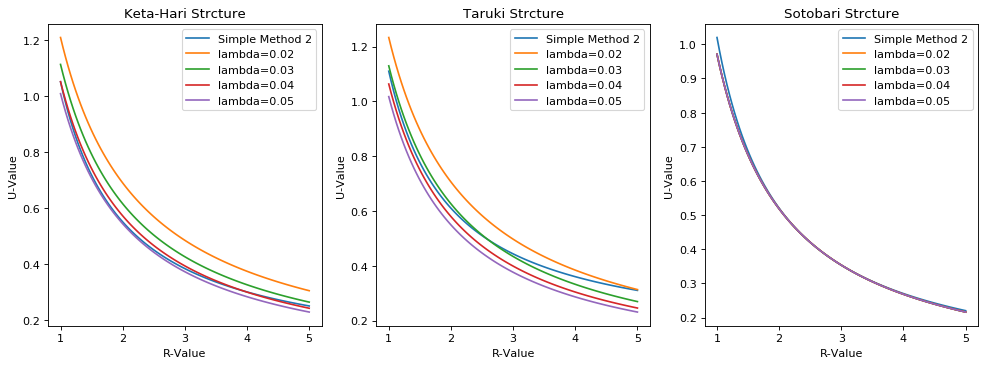

In [18]:
plt.figure(figsize=(15,5),dpi=80)

R = np.linspace(1,5,100)

plt.subplot(131)
plt.xlabel('R-Value')
plt.ylabel('U-Value')
plt.title('Keta-Hari Strcture')
plt.plot( R, 1/R+0.05, label = 'Simple Method 2')
for l in [ 0.02, 0.03, 0.04, 0.05 ]:
    plt.plot( R, U_roof_simple( True, 'Hari_Keta', l, l*R, 0, 0 ), label = 'lambda='+str(l) )
plt.legend()

plt.subplot(132)
plt.xlabel('R-Value')
plt.ylabel('U-Value')
plt.title('Taruki Strcture')
plt.plot( R, 1/R+0.11, label = 'Simple Method 2')
for l in [ 0.02, 0.03, 0.04, 0.05 ]:
    plt.plot( R, U_roof_simple( True, 'Taruki', l, l*R, 0, 0 ), label = 'lambda='+str(l) )
plt.legend()

plt.subplot(133)
plt.xlabel('R-Value')
plt.ylabel('U-Value')
plt.title('Sotobari Strcture')
plt.plot( R, 1/R+0.02, label = 'Simple Method 2')
for l in [ 0.02, 0.03, 0.04, 0.05 ]:
    plt.plot( R, U_roof_simple( True, 'Sotobari', l, l*R, 0, 0 ), label = 'lambda='+str(l) )
plt.legend()

plt.show()